# fdsreader Module

In order to analyse simulation data computed by FDS with Python, we have developed the Python module fdsreader. Its aim is to read most data output formats generated by FDS and map them to Python data structures.

It is freely available and open source. The source code is hosted at GitHub: [FireDynamics/fdsreader](https://github.com/FireDynamics/fdsreader) and there is also an [API documentation](https://firedynamics.github.io/fdsreader/index.html).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

import numpy as np

from IPython.display import display
from PIL import Image

import os
# check for set environment variable JB_NOSHOW
show = True
if 'JB_NOSHOW' in os.environ:
    show = False

## Installation

The fdsreader module can be installed via pip (see also the GitHub repository):

```
pip install fdsreader
```

However, it is already installed on all JupyterLab instances used for this lecture.

## Basic Demo Data Set

To demonstrate the usage of the fdsreader module, a simple FDS scenario ([Steckler compartment](../../examples/01_basic/02_basic_example_ii)) is utilized. Here, only a single mesh is used and only the fundamental data types are involved.

````{admonition} Full FDS input file
:class: tip, dropdown
```{literalinclude} data/fdsreader/new_example_simple_01/StecklerExample.fds
```
````

````{admonition} Precomputed simulation data
:class: tip
DOWNLOADLINK
````

### Open the Data Set

First the `fdsreader` module needs to be loaded:

In [2]:
import fdsreader

The version of (any) module can be checked with the `__version__` variable:

In [3]:
fdsreader.__version__

'1.8.6'

Next, the reader needs to be pointed to the directory, which contains the simulation data, especailly the smokeview file.

In [4]:
# define the path to the data
path_to_data = 'data/fdsreader/new_example_simple_01'

sim = fdsreader.Simulation(path_to_data)

The `Simulation` object `sim` contains now all the information and data about the simulaiton output:

In [5]:
sim

Simulation(chid=StecklerExample,
           meshes=1,
           obstructions=4,
           slices=4,
           smoke_3d=3,
           devices=4)

The variable `sim` contains information about the mesh (`MESH`), four slices (`SLCF`) and four point measurements (`DEVC`). The additional device – there were just three defined in the FDS input file – is the time column. 

```{tip}
You can use the autocomplete function in Jupyter. This way you can quickly see available data structures and functions, especially in complex data types as the `Simulation` object.
```

### Device Data

The simplest data set is the output of the `DEVC` directives. The available data and meta information can be directly printed:

In [6]:
# short reference for convinience, i.e. `devc` contains all devices
devc = sim.devices
print(devc)

[Device(id='Time', xyz=(0.0, 0.0, 0.0), quantity=Quantity('TIME')),
Device(id='Temp_Door_Low', xyz=(1.45, 0.05, 0.1), quantity=Quantity('TEMPERATURE')),
Device(id='Temp_Door_Mid', xyz=(1.45, 0.05, 1.0), quantity=Quantity('TEMPERATURE')),
Device(id='Temp_Door_High', xyz=(1.45, 0.05, 1.65), quantity=Quantity('TEMPERATURE'))]


The `Device` class contains all relevant information, see [device documentation](https://firedynamics.github.io/fdsreader/devc.html). 

In [7]:
for i in devc:
    print(f"ID: {i.id},\t quantity: {i.quantity_name}, \t position: {i.position}")

ID: Time,	 quantity: TIME, 	 position: (0.0, 0.0, 0.0)
ID: Temp_Door_Low,	 quantity: TEMPERATURE, 	 position: (1.45, 0.05, 0.1)
ID: Temp_Door_Mid,	 quantity: TEMPERATURE, 	 position: (1.45, 0.05, 1.0)
ID: Temp_Door_High,	 quantity: TEMPERATURE, 	 position: (1.45, 0.05, 1.65)


```{tip} Autocomplete works also for the dictionary keys ;-)
```
Individual devices, including the time column, are accessable as dictironary entries using their `ID` as key. The data of each individual device (`Device.data`) is stored as a numpy array:

In [8]:
type(devc['Temp_Door_Mid'].data)

numpy.ndarray

The length matches the expected value, i.e. 1801, as the simulation time was $\mf 1800\ s$ and the divices were writen out every second, including the initial time step, here at $\mf t=0\ s$. 

In [9]:
len(devc['Time'].data)

1801

A raw look at the data (`Device.data`):

In [10]:
devc['Temp_Door_Mid'].data

array([ 20.      ,  20.002083,  20.034418, ..., 105.32822 , 114.82179 ,
       115.01705 ], dtype=float32)

The device data can be also visualised with matplotlib:

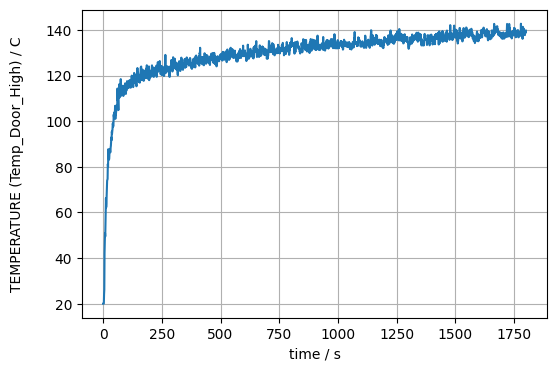

In [11]:
# create the plot
plt.plot(devc['Time'].data, devc['Temp_Door_High'].data)

# label the axes
plt.xlabel("time / s")
devc_id = devc['Temp_Door_High'].id
devc_q = devc['Temp_Door_High'].quantity_name
devc_u = devc['Temp_Door_High'].unit
plt.ylabel(f"{devc_q} ({devc_id}) / {devc_u}")

# add a grid
plt.grid()

# save output to file
plt.savefig('figs/device_demo_01.svg', bbox_inches='tight')

# supress double output on webpage 
if not show: plt.close()

:::{figure-md} fig-fdsreader-device-demo-plot-01

<img src="figs/device_demo_01.svg" width="80%">

Visualization of the data of one of the devices.
:::

In the same manner a set of devices can be plotted at once. Like all devices with names starting with `Temp_`:

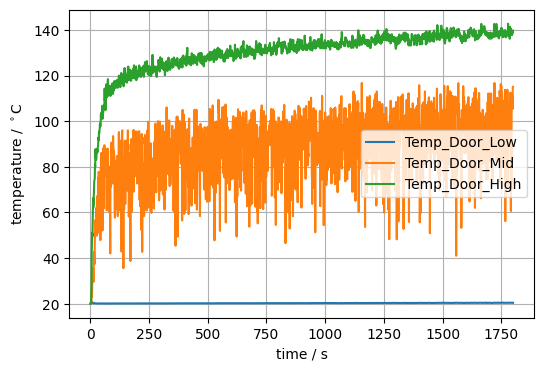

In [12]:
# loop over all devices
for i in devc:
    
    # consider only devices with an ID that starts with 'Temp_'
    if not i.id.startswith('Temp_'): 
        continue
    
    plt.plot(devc["Time"].data, i.data, label=i.id)
    
plt.legend()
plt.xlabel("time / s")
plt.ylabel('temperature / $^\circ$C')
plt.grid()

# save output to file
plt.savefig('figs/device_demo_02.svg', bbox_inches='tight')

# supress double output on webpage 
if not show: plt.close()

:::{figure-md} fig-fdsreader-device-demo-plot-02

<img src="figs/device_demo_02.svg" width="80%">

Visualization of the data of a set of devices.
:::

### HRR Data

In the same fashion as the `DEVC` data, the data written to the `HRR` file can be directly accessed. It is not stored in the `devices` but in the `hrr` element of the `Simulation` object.

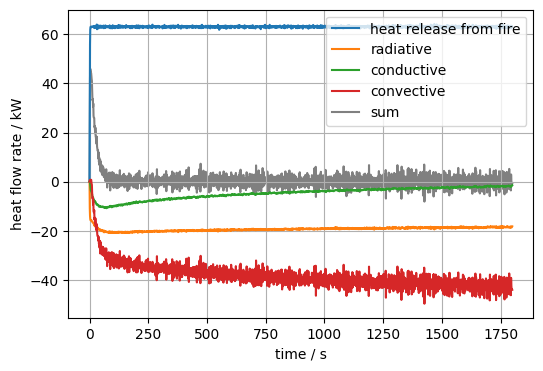

In [13]:
plt.plot(sim.hrr['Time'], sim.hrr['HRR'], label='heat release from fire')

plt.plot(sim.hrr['Time'], sim.hrr['Q_RADI'], label='radiative')
plt.plot(sim.hrr['Time'], sim.hrr['Q_COND'], label='conductive')
plt.plot(sim.hrr['Time'], sim.hrr['Q_CONV'], label='convective')

plt.plot(sim.hrr['Time'], 
         sim.hrr['HRR'] + sim.hrr['Q_RADI'] + sim.hrr['Q_COND'] + sim.hrr['Q_CONV'], 
         color='grey', label='sum', zorder=0)

plt.xlabel('time / s')
plt.ylabel('heat flow rate / kW')
plt.legend()

plt.grid()

# save output to file
plt.savefig('figs/hrr_demo_01.svg', bbox_inches='tight')

# supress double output on webpage 
if not show: plt.close()


:::{figure-md} fig-fdsreader-hrr-demo-plot-01

<img src="figs/hrr_demo_01.svg" width="80%">

Visualization of a set of columns from the `HHR` file.
:::

### Slice Data

Data generated by `SLCF` directives span over two or three spatial dimensions plus the time dimension. Besides that, they can be distributed across multiple meshes. 

In [14]:
# print available slice data
for slice in sim.slices:
    print(slice.quantity, slice.extent)

Quantity('TEMPERATURE') Extent([0.00, 0.00] x [-1.40, 1.40] x [0.00, 2.20])
Quantity('TEMPERATURE') Extent([-1.40, 2.60] x [0.00, 0.00] x [0.00, 2.20])
Quantity('TEMPERATURE') Extent([0.10, 0.10] x [-1.40, 1.40] x [0.00, 2.20])
Quantity('TEMPERATURE') Extent([-1.40, 2.60] x [0.10, 0.10] x [0.00, 2.20])


In [15]:
# choose (output) time step, next to t=7.5 s
it = sim.slices[1].get_nearest_timestep(700.5)
print(f"Time step: {it}")
print(f"Simulation time: {sim.slices[0].times[it]}")

Time step: 700
Simulation time: 700.0132


The data of a slice is stored for each mesh individually. In this simple example, there is only a single mesh, yet for formal consistency it still needs to be referred.

The sturcutre is as follows

```
sim.slices[sliceid][meshid].data[timestep, direction1, direction2]
```

where `sliceid` is just the index of the slice, `meshid` is the index of the mesh, here 0, and the reference to the data is given by the time step id and then the two spatial indices.

The following example illustrates the visualisation of the data and steps needed to adjust the representation.

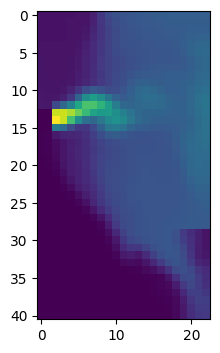

In [16]:
# Initial visualasation of the data
plt.imshow(sim.slices[1][0].data[it]);

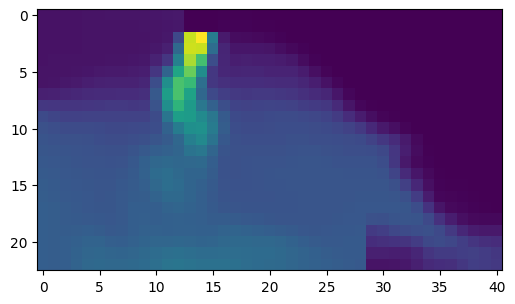

In [17]:
# Access the transpose data using ndarray.T
plt.imshow(sim.slices[1][0].data[it].T);

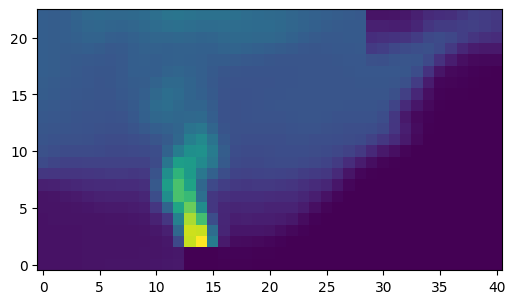

In [18]:
# The default origin of matplotlib's imshow is not suited 
# for our case. Thus the origin is set to 'lower'.
plt.imshow(sim.slices[1][0].data[it].T, origin='lower');

Text(0, 0.5, 'z coordinate / m')

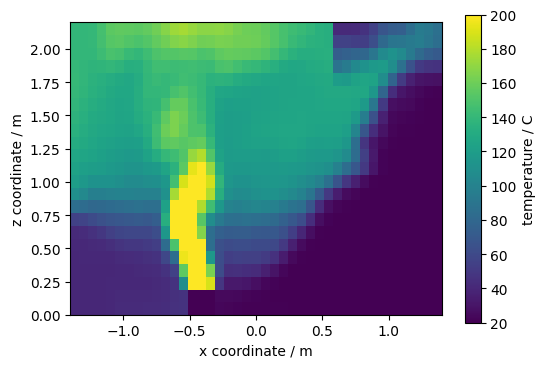

In [19]:
# Finally, also the extend is specified to move from index to physical space
plt.imshow(sim.slices[1][0].data[it].T, 
           origin='lower',
           vmax=200,
           extent=sim.slices[0].extent.as_list())
plt.colorbar(label='temperature / C');
plt.xlabel('x coordinate / m')
plt.ylabel('z coordinate / m')

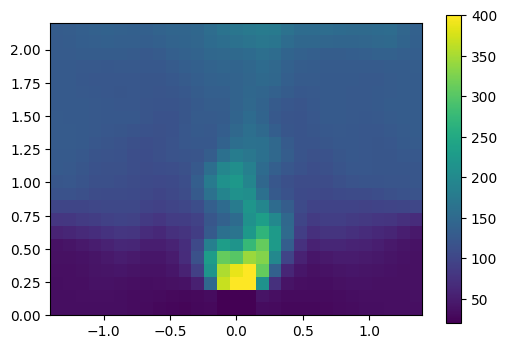

In [20]:
# Example of limiting the shown values
plt.imshow(sim.slices[0][0].data[it].T,
           vmax=400,
           origin='lower', 
           extent=sim.slices[0].extent.as_list())
plt.colorbar();

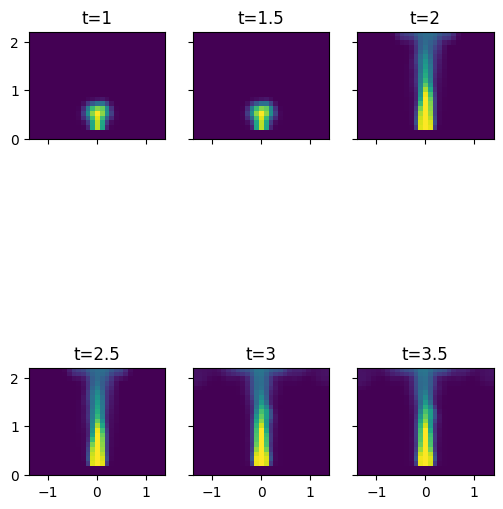

In [21]:
# Example for a multi plot
slice = sim.slices[0]
list_t = [1, 1.5, 2, 2.5, 3, 3.5]
fig, axs = plt.subplots(2,3, figsize=(6,8), sharex=True, sharey=True)
for i in range(len(list_t)):
    it = slice.get_nearest_timestep(list_t[i])
    axs.flat[i].imshow(slice[0].data[it].T,
                       vmin=20,
                       vmax=400,
                       origin='lower', 
                       extent=slice.extent.as_list())
    axs.flat[i].set_title(f"t={list_t[i]}")

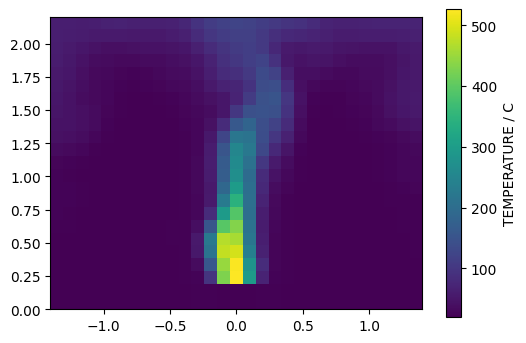

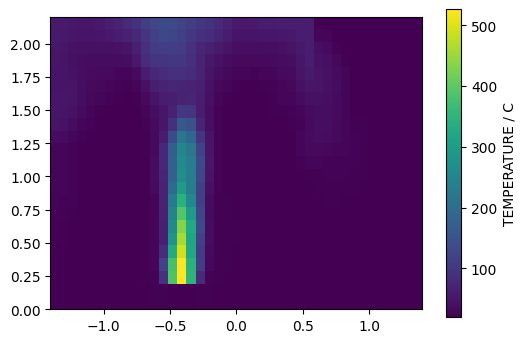

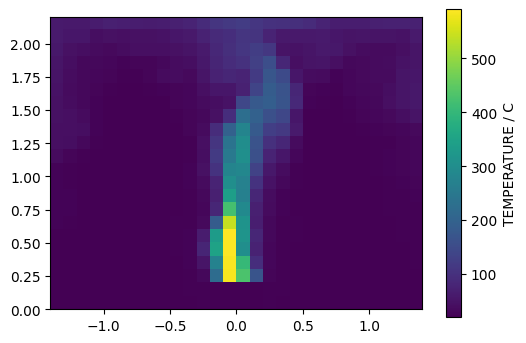

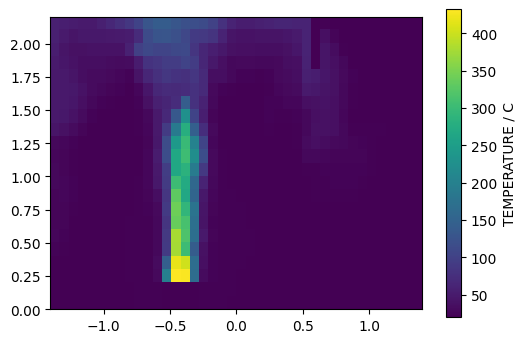

In [22]:
# Example for a multi plot
slice_n = len(sim.slices)
it = sim.slices[0].get_nearest_timestep(7.5)
for i in range(slice_n):
    plt.imshow(sim.slices[i][0].data[it].T,
               origin='lower', 
               extent=slice.extent.as_list())
    q = sim.slices[i].quantity.quantity
    u = sim.slices[i].quantity.unit
    plt.colorbar(label=f"{q} / {u}")
    plt.show()